# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import plotly.graph_objects as go
import glob
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
# user written modules
import dataproject
from pandas_datareader import wb
import seaborn as sns
import folium 
import mapclassify

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

Import your data, either through an API or manually, and load it. 

In [191]:
data = pd.read_csv('Population estimates 1992-2001.csv')
data = pd.merge(data, pd.read_csv('Population estimates 2002-2019.csv'), how='outer',validate='one_to_one')

In [192]:
data.head()

,Age,Sex,1992,1993,1994,1995,1996,1997,1998,1999,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,Males,262256,293100,281875,274171,269122,273472,273404,270959,...,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,248552,277354,266660,258677,253857,258096,258674,255666,...,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,510808,570454,548535,532848,522979,531568,532078,526625,...,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,267914,264589,292378,280911,273119,268728,271549,270301,...,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,255186,251203,276723,265953,258026,253591,256424,255967,...,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360


In [193]:
#rename variables to be more informative and easier to work with
col_dict = {}
for i in range(1992, 2019+1):
    col_dict[str(i)] = f'pop{i}'

col_dict = {str(i) : f'pop{i}' for i in range(1992, 2019+1)}

data.rename(columns = col_dict, inplace=True)
data.head()

,Age,Sex,pop1992,pop1993,pop1994,pop1995,pop1996,pop1997,pop1998,pop1999,...,pop2010,pop2011,pop2012,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019
0,0,Males,262256,293100,281875,274171,269122,273472,273404,270959,...,289377,284926,276371,274396,263091,257024,248474,241228,234151,221685
1,0,Females,248552,277354,266660,258677,253857,258096,258674,255666,...,272945,268292,260976,259651,249049,242916,234503,228728,220915,209322
2,0,Total,510808,570454,548535,532848,522979,531568,532078,526625,...,562322,553218,537347,534047,512140,499940,482977,469956,455066,431007
3,1,Males,267914,264589,292378,280911,273119,268728,271549,270301,...,292642,288996,284199,277263,274308,262728,256954,248341,241422,234386
4,1,Females,255186,251203,276723,265953,258026,253591,256424,255967,...,277321,272698,267521,261900,259608,248720,242753,234634,228990,221360


In [194]:
#reshape data from wide to long format
pop_italy = pd.wide_to_long(data, stubnames='pop', i=['Age','Sex'], j='year')
pop_italy = pop_italy.reset_index()
pop_italy.head(10)

,Age,Sex,year,pop
0,0,Males,1992,262256
1,0,Males,1993,293100
2,0,Males,1994,281875
3,0,Males,1995,274171
4,0,Males,1996,269122
5,0,Males,1997,273472
6,0,Males,1998,273404
7,0,Males,1999,270959
8,0,Males,2000,272792
9,0,Males,2001,274518


In [195]:
# Let's reshape the data to wide format again
pop_italy_wide = pop_italy.pivot(index=['year','Age'], columns='Sex', values='pop')
pop_italy_wide.sort_values(['year','Age'], inplace=True)
pop_italy_wide.reset_index(inplace=True)
pop_italy_wide.columns.name = None
pop_italy_wide.head(10)

,year,Age,Females,Males,Total
0,1992,0,248552,262256,510808
1,1992,1,255186,267914,523100
2,1992,10,300206,313202,613408
3,1992,100 and over,2229,623,2852
4,1992,11,305720,319714,625434
5,1992,12,318337,332506,650843
6,1992,13,340988,355326,696314
7,1992,14,356648,370807,727455
8,1992,15,377406,392536,769942
9,1992,16,401499,416912,818411


In [196]:
#let's now add year equal to 2020 and 2021
data_2020 = pd.read_csv('Resident_population_2020.csv')
data_2020['year'] = 2020
data_2021 = pd.read_csv('Resident_population_2021.csv')
data_2021['year'] = 2021

data_new = pd.concat([data_2020, data_2021], ignore_index=True)

#rename variables in order to have the same names of the other dataset with which I have to append
data_new.rename(columns = {'Total males' : 'Males', 'Total females': 'Females'}, inplace=True)



In [197]:
#creating a dataset that contains the population from 1991 to 2021
pop_italy = pd.concat([pop_italy_wide, data_new], ignore_index=True)

In [198]:
#as we can see the column age is not in the right format. We need to change it to int but we have to deal with  '100 and other' and 'Total' observations 
pop_italy.info()

#we can drop the observation relative to the total  
pop_italy = pop_italy[pop_italy['Age'] != 'Total']

#Since 100 or other will be included in the same group of 100. we replace  '100 and other' with 100
pop_italy['Age'] = pop_italy['Age'].replace('100 and over', '100')

#Now we can change the column to int
pop_italy['Age'] = pop_italy['Age'].astype(int)


#Let's now sort the dataset
pop_italy.sort_values(['year','Age'], inplace=True)
pop_italy.reset_index(drop=True, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     3060 non-null   int64 
 1   Age      3060 non-null   object
 2   Females  3060 non-null   int64 
 3   Males    3060 non-null   int64 
 4   Total    3060 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 119.7+ KB


In [199]:
pop_italy.head(10)

,year,Age,Females,Males,Total
0,1992,0,248552,262256,510808
1,1992,1,255186,267914,523100
2,1992,2,257770,270613,528383
3,1992,3,259784,273681,533465
4,1992,4,254547,267722,522269
5,1992,5,257606,270798,528404
6,1992,6,269742,281702,551444
7,1992,7,274275,286983,561258
8,1992,8,281761,295917,577678
9,1992,9,293124,305422,598546


In [200]:
# Create a new column with the age group of each observation
pop_italy['age_group'] = ''

for i in range(0, 101, 5):
    if i == 100:
        pop_italy.loc[pop_italy['Age'].between(i, i+5), 'age_group'] = '100-100+'
    else:
        pop_italy.loc[pop_italy['Age'].between(i, i+4), 'age_group'] = f'{i}-{i+4}'

# Summing up all the observations for each age group
pop_italy_agg = pop_italy.groupby(['age_group', 'year'])[['Males', 'Females','Total']].sum()

# Resetting index
pop_italy_agg.reset_index(inplace=True)

# Splitting age_group into lower_bound and upper_bound in order to sort the age groups correctly
pop_italy_agg[['lower_bound', 'upper_bound']] = pop_italy_agg['age_group'].str.split('-', expand=True)

# Sorting by age groups
pop_italy_agg['lower_bound'] = pop_italy_agg['lower_bound'].astype(int)
pop_italy_agg.sort_values(['year','lower_bound'], inplace=True)
pop_italy_agg.reset_index(inplace=True)
pop_italy_agg.drop(['index', 'lower_bound', 'upper_bound'], axis=1, inplace=True)



In [201]:
pop_italy_agg.head(10)

,age_group,year,Males,Females,Total
0,0-4,1992,1342186,1275839,2618025
1,5-9,1992,1440822,1376508,2817330
2,10-14,1992,1691555,1621899,3313454
3,15-19,1992,2140091,2062555,4202646
4,20-24,1992,2314913,2243348,4558261
5,25-29,1992,2355948,2320969,4676917
6,30-34,1992,2075333,2063616,4138949
7,35-39,1992,1902433,1913343,3815776
8,40-44,1992,1964807,1984476,3949283
9,45-49,1992,1734308,1770641,3504949


In [202]:
#Let's now plot the total population in italy by age_group
def plot_pop(df, age_group): 
    I = df['age_group'] == age_group
    ax=df.loc[I,:].plot(x='year', y='Total', style='-o', legend=False)
    ax.set_ylabel('Population')
    ax.set_title(f'Population in age group {age_group}')

In [203]:
widgets.interact(plot_pop, 
    df = widgets.fixed(pop_italy_agg),
    age_group = widgets.Dropdown(description='Age_group', 
                                    options=pop_italy_agg['age_group'].unique(), 
                                    value='0-4')
);

interactive(children=(Dropdown(description='Age_group', options=('0-4', '5-9', '10-14', '15-19', '20-24', '25-…

In [204]:
#now we can plot the population by age group and by sex in Italy in different years. So that we are able to see the evolution of the age structure of the population in Italy.

def plot_func(df, year):
    I = df['year'] == year
    fig = go.Figure()
    # Adding male population data as positive values
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Males'],
        name='Male',
        orientation='h')
    )

    # Adding female population data as negative values to plot in opposite direction
    fig.add_trace(go.Bar(
        y=df.loc[I, 'age_group'],
        x=df.loc[I, 'Females'] * -1,  # Multiplying by -1 to plot in opposite direction
        name='Female',
        orientation='h')
    )
    
    fig.update_layout(
        template='plotly_white',
        title=f'Population in Italy {year}',
        title_font_size=24,
        barmode='relative',
        bargap=0.1,  # Adjust as needed
        bargroupgap=0.2,  # Adjust as needed
        xaxis_title='Population',
        xaxis=dict(
            tickvals=[-2000000, -1000000, 0, 1000000, 2000000],
            ticktext=['2M', '1M', '0', '1M', '2M']),
        width=800,
        height=600)
    fig.show()
      
    
    

# Create an interactive widget with a slider to choose the year
widgets.interact(plot_func,
                 df=widgets.fixed(pop_italy_agg),
                 year=widgets.IntSlider(description='Year',
                                        min=pop_italy_agg['year'].min(),
                                        max=pop_italy_agg['year'].max(),
                                        step=1,
                                        value=pop_italy_agg['year'].min(),
                                        continuous_update=True)
                                     
)


interactive(children=(IntSlider(value=1992, description='Year', max=2021, min=1992), Output()), _dom_classes=(…

<function __main__.plot_func(df, year)>

In [205]:
# Downloading life expectancy data for Italy
wb_fr = wb.download(indicator='SP.DYN.LE00.IN', country=['IT'], start=1992, end=2021)
wb_fr.reset_index(inplace=True)
wb_fr.rename(columns={'SP.DYN.LE00.IN': 'life_expectancy'}, inplace=True)


In [206]:
#the variable year is an object but it should be an integer
wb_fr.info()
wb_fr['year'] = wb_fr['year'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          30 non-null     object 
 1   year             30 non-null     object 
 2   life_expectancy  30 non-null     float64
dtypes: float64(1), object(2)
memory usage: 852.0+ bytes


In [207]:
# Downloading birth rate data for Italy
wb_birth = wb.download(indicator='SP.DYN.CBRT.IN', country=['IT'], start=1992, end=2021)
wb_birth.reset_index(inplace=True)
wb_birth.rename(columns={'SP.DYN.CBRT.IN': 'birth_rate'}, inplace=True)

In [208]:
wb_birth.info()

#the variable year is an object but it should be an integer
wb_birth['year'] = wb_birth['year'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     30 non-null     object 
 1   year        30 non-null     object 
 2   birth_rate  30 non-null     float64
dtypes: float64(1), object(2)
memory usage: 852.0+ bytes


In [209]:
# Merging dataframes on 'year'
merged_df = pd.merge(wb_fr, wb_birth, how='outer',on='year')

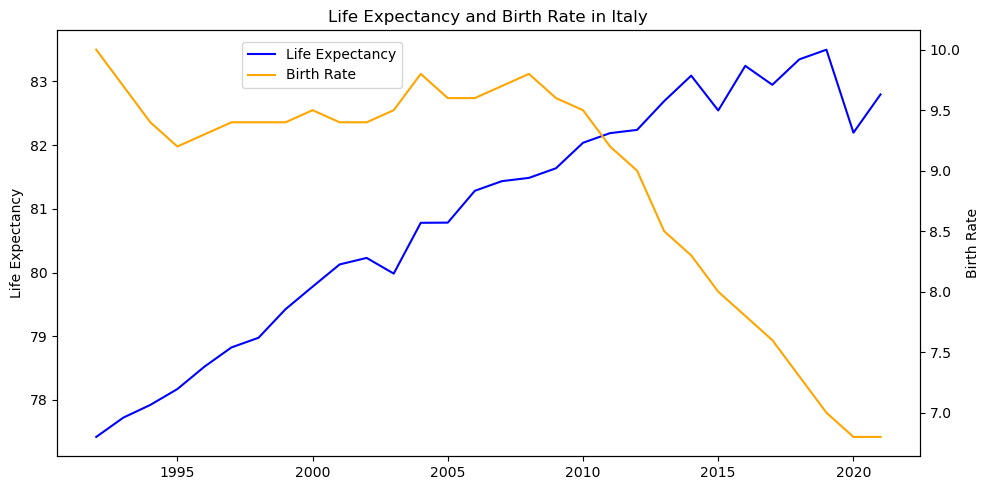

In [210]:
# Creating a figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plotting life expectancy on primary y-axis
ax1.plot(merged_df['year'], merged_df['life_expectancy'], color='blue', label='Life Expectancy')
ax1.set_ylabel('Life Expectancy', color='black')

# Creating a secondary y-axis for birth rate
ax2 = ax1.twinx()
ax2.plot(merged_df['year'], merged_df['birth_rate'], color='orange', label='Birth Rate')
ax2.set_ylabel('Birth Rate', color='black')

# Adding title and legend
plt.title('Life Expectancy and Birth Rate in Italy')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.24, 0.92))                                 
plt.show()

In [215]:
# Read the CSV file. The file has been constructed in a wrong way, so we need to fix it
regional_fertility = pd.read_csv('Fertility.csv')
regional_fertility.head()

,Event year,Territory,1st order fertility rate,2nd order fertility rate,3rd order and more fertility rate,Total fertility rate,Notes
0,1992,Piemonte,60,38,10,108,NaN
1,1992,Valle d'Aosta/Vallée d'Aoste,59,41,11,110,NaN
2,1992,Liguria,59,35,8,103,NaN
3,1992,Lombardia,60,40,12,112,NaN
4,1992,Trentino-Alto Adige/Südtirol,71,49,21,142,NaN


In [216]:
#keep only variables of interest 
keep_vars = ['Territory', 'Total fertility rate', 'Event year']
regional_fertility = regional_fertility[keep_vars]
regional_fertility.head()

,Territory,Total fertility rate,Event year
0,Piemonte,108,1992
1,Valle d'Aosta/Vallée d'Aoste,110,1992
2,Liguria,103,1992
3,Lombardia,112,1992
4,Trentino-Alto Adige/Südtirol,142,1992


In [217]:
# Function to insert dot after first digit in a string of lenght 3 or 0. if the string has length 2
def insert_dot(value):
    if len(str(value)) == 2:
        return '0.' + str(value)
    return str(value)[:1] + '.' + str(value)[1:]

# Apply the function to the '2021' column
regional_fertility['Total fertility rate'] = regional_fertility['Total fertility rate'].apply(lambda x: insert_dot(x))
# Convert the '2021' column to integers
regional_fertility['Total fertility rate'] = regional_fertility['Total fertility rate'].astype(float)

# Rename the columns
regional_fertility.rename(columns={'Territory': 'region', 'Total fertility rate': 'total_fertility_rate', 'Event year': 'year'}, inplace=True)

In [227]:
regional_fertility.sample(10)

,region,total_fertility_rate,year
237,Provincia Autonoma di Trento,1.41,2003
390,Sardegna,1.16,2009
338,Molise,1.18,2007
17,Calabria,1.64,1992
492,Friuli-Venezia Giulia,1.39,2014
371,Liguria,1.36,2009
483,Italia,1.39,2013
479,Basilicata,1.13,2013
658,Lazio,1.18,2021
27,Friuli-Venezia Giulia,0.96,1993


In [232]:
# Create a figure for total factor productivity 
def plot(df,year):
    I = df['year'] == year
    plt.figure(figsize=(7, 5))

# Subplot for Fertility Rate
    plt.subplot(1, 1, 1)  
    sns.histplot(data=df, x=df.loc[I,'total_fertility_rate'], bins=8, kde=True, color='lightgreen')
    plt.xlabel('Fertility Rate')
    plt.ylabel('Density')
    plt.title(f'Fertility Rate in {year}')
    plt.show()

In [92]:


# Raw URL to the GeoJSON file
geojson_url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson'

# Assuming you have 'regional_fertility' DataFrame with fertility data for Italian regions

# Create a choropleth map figure for Italian regions
fig = go.Figure(
    go.Choroplethmapbox(
        
        # Assign GeoJSON file
        geojson=geojson_url,
        
        # Assign feature key from GeoJSON
        featureidkey='properties.reg_name',
        
        # Assign location data
        locations=regional_fertility['Territory'],
        
        # Assign information/value data
        z=regional_fertility['2018'],
        zauto=True,
        
        # Assign colorscale to be used
        colorscale='thermal',
        showscale=True,
    )
)

# Update layout
fig.update_layout(
    
    # Decide a style for the map
    mapbox_style='carto-positron',
    
    # Zoom in scale
    mapbox_zoom=5.6, 
    
    # Center location of the map using relevant coordinates for Italy
    mapbox_center={'lat':41.63948698417683, 'lon': 12.668218301890061}
,
    
    # Setting width of figure and hereafter height
    width=1000,
    height=850,
    
    # Setting title, font, and text color 
    title_text='Fertility Rate in Italian Regions',
    font=dict(
        family='Courier New, monospace',
        color='black',
    )
)

# Display figure
fig.show()


## Explore each data set

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.